In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('used car data with other.csv')

In [19]:
df.columns

Index(['price', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer',
       'transmission', 'drive', 'size', 'type', 'age'],
      dtype='object')

In [4]:
df.head()

,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,age
0,9500,chrysler,excellent,6 cylinders,gas,30376.0,automatic,fwd,mid-size,mini-van,18.0
1,18250,toyota,good,6 cylinders,gas,201300.0,manual,4wd,full-size,offroad,13.0
2,6800,other,excellent,6 cylinders,diesel,180000.0,automatic,rwd,full-size,bus,16.0
3,2500,other,good,6 cylinders,gas,47000.0,manual,rwd,full-size,pickup,55.0
4,4000,jeep,good,6 cylinders,gas,281000.0,automatic,rwd,mid-size,SUV,15.0


### Prepare the dataset

In [20]:
from sklearn.preprocessing import LabelEncoder

cat_columns = ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'size', 'type']

for col in cat_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

I used the label encoder rather than dummy to get simpler model with the least features in the model, cause in the data the categorical column ratio is 8 out of 10. I can also use dummy with the same result, but its increase the computational cost.

In [6]:
df.head()

,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,age
0,9500,8,0,5,2,30376.0,0,1,2,5,18.0
1,18250,39,2,5,2,201300.0,1,0,1,6,13.0
2,6800,31,0,5,0,180000.0,0,2,1,1,16.0
3,2500,31,2,5,2,47000.0,1,2,1,8,55.0
4,4000,19,2,5,2,281000.0,0,2,2,0,15.0


In [21]:
y = df['price']
X = df.drop(columns='price')

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Compare the regression models

I compare some regression algorithm to get the basic idea of the idea of how is the model behave on the default parameters on the algorithms. here I choose the top 3 algorithms

In [ ]:
def model_selection(X_train, y_train, X_test, y_test, models):
    
    from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
    
    R2_result = []
    MSE_result = []
    str_models = []
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        MSE = mean_squared_error(y_test, y_pred)
        R2 = r2_score(y_test, y_pred)       
        R2_result.append(R2)
        MSE_result.append(MSE)  
        str_models.append(str(model))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

    ax1.plot(R2_result)
    ax1.set_ylabel('R2_score')


    ax2.plot(str_models,np.sqrt(MSE_result))
    ax2.set_ylabel('RMSE_result')
    ax2.set_xticklabels(str_models, rotation=90)
    plt.tight_layout()
    
    return pd.DataFrame({'models':models, 'R2':R2_result, 'RMSE':np.sqrt(MSE_result)}) 

https://github.com/codebasics/py/blob/master/ML/15_gridsearch/15_grid_search.ipynb
https://github.com/justmarkham/scikit-learn-videos/blob/master/08_grid_search.ipynb

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

,models,R2,RMSE
0,LinearRegression(),0.204244,8008.263122
1,Ridge(),0.204246,8008.256016
2,Lasso(),0.204286,8008.052592
3,BayesianRidge(),0.204284,8008.062836
4,SVR(),0.001867,8968.972933
5,KNeighborsRegressor(),0.705696,4870.194552
6,DecisionTreeRegressor(),0.602034,5663.325346
7,"(DecisionTreeRegressor(random_state=54351094),...",0.753165,4460.172915
8,"(DecisionTreeRegressor(max_features='auto', ra...",0.775639,4252.281842
9,"(DecisionTreeRegressor(max_depth=3, random_sta...",0.198091,8039.168641


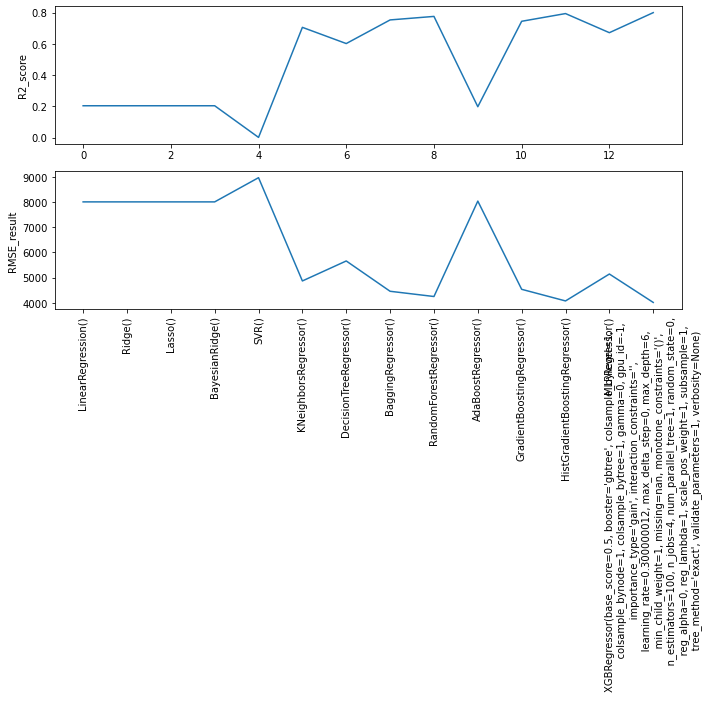

In [30]:
models = [LinearRegression(), Ridge(), Lasso(), BayesianRidge(), SVR(), KNeighborsRegressor(),
          DecisionTreeRegressor(), BaggingRegressor(), RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(),
          HistGradientBoostingRegressor(), MLPRegressor(), XGBRegressor()]

model_selection(X_train, y_train, X_test, y_test, models)   

### Cross Validation for the best model in model comparasion

In [25]:
def acc_CV(model, X, y):
    from sklearn.model_selection import cross_val_score

    accuracies = cross_val_score(estimator = model, X= X, y=y,  cv=10)
    accuracies.mean()
    accuracies.std()
    print('akurasi  {:.2f}% +/- {:.2f}%' .format(accuracies.mean()*100, accuracies.std()*100))

In [26]:
rf = RandomForestRegressor()
HGB = HistGradientBoostingRegressor()
XGB = XGBRegressor()

In [27]:
acc_CV(rf, X, y)

akurasi  76.50% +/- 2.65%


In [16]:
acc_CV(rf, X_train, y_train)

akurasi  77.36% +/- 1.02%


In [35]:
acc_CV(HGB, X_train, y_train)

akurasi  79.11% +/- 1.04%


In [33]:
acc_CV(XGB, X_train, y_train)

akurasi  79.43% +/- 1.05%


## Random Forest model

### Feature importances in the model

Text(0.5, 1.0, 'Feature Importances')

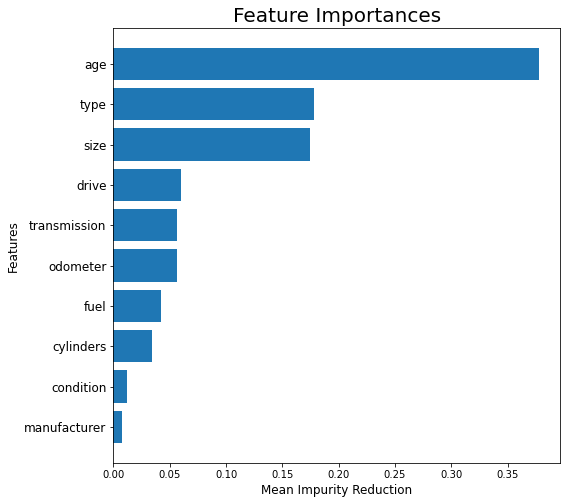

In [38]:
tree_feature =  pd.Series(rf.feature_importances_, df.drop(columns='price').columns).sort_values(ascending = True)
plt.figure(figsize = (8,8))
plt.barh(df.drop(columns='price').columns, tree_feature)
plt.xlabel('Mean Impurity Reduction', fontsize = 12)
plt.ylabel('Features', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Feature Importances', fontsize = 20)

### Iterate the process

Iterate the process of the designing the features of the data to get more accuracy in the model

https://medium.com/purwadhikaconnect/metode-feature-importance-dalam-data-science-yang-perlu-kamu-ketahui-6b4f35db6476

### Hyperparameter using RandomizedsearchCV for wide range analysis

In [29]:
def model_randomCV(X, y):
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestRegressor
    
    model_parameter = {'model':RandomForestRegressor(), 'parameters':{'n_estimators': np.arange(100, 500, 50),
                                                                              'max_features':['auto', 'sqrt'], 
                                                                              'max_depth':np.arange(10,110, 10), 
                                                                     'min_samples_split':np.arange(1, 6, 1), 
                                                                     'min_samples_leaf':np.arange(1,6,1)}}
    
    randCV = RandomizedSearchCV(estimator=model_parameter['model'], param_distributions=model_parameter['parameters'], cv=5)
    randCV.fit(X, y)
    
    return randCV.cv_results_
    
    print('best_parameters: ' + str(randCV.best_params_))
    print('best_score: ' + str(randCV.best_score_))
    print('best_estimator: ' + str(randCV.best_estimator_))

In [30]:
model_randomCV(X, y)

best_parameters: {'n_estimators': 340, 'max_features': 'sqrt', 'max_depth': 40}
best_score: 0.7724885116915412


### Tuning parameters for narrower range using GridsearchCV

In [11]:
def tuning_param(X, y, model, parameters):
    
    from sklearn.model_selection import GridSearchCV   
        
    scores = []
   
    fig, axs = plt.subplots(len(parameters))
    k = 0   
    for parameter in parameters:
        
        clf = GridSearchCV(estimator = model, param_grid = parameter, cv=3, scoring='r2')
        clf.fit(X, y)
        

        for name_param, val_param in parameter.items():
            
            grid_mean_scores = clf.cv_results_['mean_test_score']

            axs[k].plot(val_param, grid_mean_scores)
            axs[k].set_xlabel(name_param)
            axs[k].set_ylabel('R2')
            k+=1
            
            
        scores.append({'parameter':name_param,
                       'best_R2':clf.best_score_,
                       'best_value':clf.best_params_})
            
    plt.tight_layout()       
    return pd.DataFrame(scores, columns=['parameter', 'best_R2', 'best_value'])

KeyboardInterrupt: 

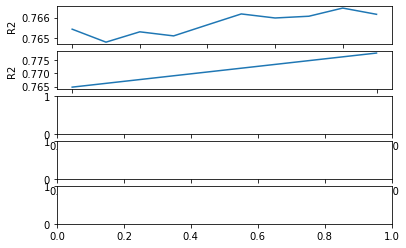

In [13]:
parameters = [{'n_estimators': np.arange(100, 200, 10)}, {'max_features':['auto', 'sqrt']}, 
              {'max_depth':np.arange(10,250, 10)}, {'min_samples_split':np.arange(1, 5, 1)}, 
             {'min_samples_leaf':np.arange(1,5,1)}]
tuning_param(X_train, y_train, rf, parameters)

### underfit and overfit check

1. Overfitting is when the model’s error on the training set (i.e. during training) is very low but then, the model’s error on the test set (i.e. unseen samples) is large!

2. Underfitting is when the model’s error on both the training and test sets (i.e. during training and testing) is very high.

https://towardsdatascience.com/is-your-model-overfitting-or-maybe-underfitting-an-example-using-a-neural-network-in-python-4faf155398d2

In [28]:
def fit_check(model, kfolds):
    
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error
    
    kf = KFold(n_splits=kfolds)
    list_training_error = []
    list_testing_error = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_train_data_pred = model.predict(X_train)
        y_test_data_pred = model.predict(X_test)
        fold_training_error = mean_absolute_error(y_train, y_train_data_pred) 
        fold_testing_error = mean_absolute_error(y_test, y_test_data_pred)
        list_training_error.append(fold_training_error)
        list_testing_error.append(fold_testing_error)

    plt.subplot(1,2,1)
    plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel(), 'o-')
    plt.xlabel('number of fold')
    plt.ylabel('training MEA')
    plt.title('Training MEA across folds')
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel(), 'o-')
    plt.xlabel('number of fold')
    plt.ylabel('testing MEA')
    plt.title('Testing MEA across folds')
    plt.tight_layout()
    plt.show()

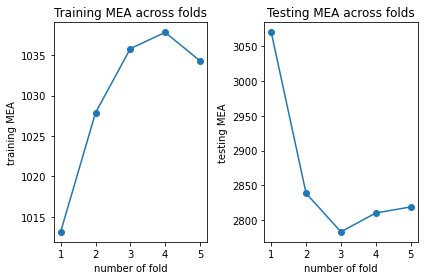

In [30]:
fit_check(rf, 5)

### Final predicted model

### save the model to pickle